# HYBRID INTRUSION DETECTION SYSTEM (PLACEHOLDER)

This is the code for the paper " "

Author: William S. Ventura (w.stephan.ventura@gmail.com)
Organization: Whiting School of Engineering, Johns Hopkins University

## IMPORT LIBRARIES

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [39]:
import pandas as pd
import numpy as np
import optunity
import optunity.metrics
from sklearn.preprocessing import LabelEncoder
from genetic_selection import GeneticSelectionCV
from sklearn_genetic import GAFeatureSelectionCV
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn_genetic.plots import plot_fitness_evolution
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.metrics import f1_score, roc_auc_score
import hdbscan
import xgboost as xgb
from xgboost import plot_importance

## Reading in the CIC_Collection Dataset

The CIC Collection Dataset is a combination of CIC-IDS2017, CIC-DoS2017, CSE-CIC-IDS2018 and CIC-DDoS2019. Publicly available on Kaggle @ https://www.kaggle.com/code/dhoogla/cic-collection-00-clean-up

Note: The cleaned up version of this collection has removed contaminated features found in the CIC datasets and other NIDS datasets which have equal blind predictive power across all available attack classes, despite having had access to only one attack class during training.
The features which contaminate the CIC collection dataset in the aforementioned way are in order of severity:

    PSH Flag Count, ECE Flag Count, RST Flag Count, ACK Flag Count
    Fwd Packet Length Min
    Bwd Packet Length Min
    Packet Length Min
    Protocol


Note: At the start of this project the original cic-collection was used, it was later modified to use the cleaned up version, both .parquet files are available in the "ids_data" folder

Note: Due to the massive size of the dataset and hardware limitations, a sampled subset of CIC_Collection is used. The subsets are in the "ids_data" folder.

In [6]:
# Load Dataset
pd.set_option('display.max_columns', None)
df = pd.read_parquet("./ids_data/cic-collection.parquet")

In [7]:
# Drop unnecessary columns (Extra Label Column)
df.drop(columns=["Label"], axis=1, inplace=True)
df.shape

(9167581, 78)

## Improving the CIC Collection
###  1.Removing contaminating features
### Improved CIC will be compared against feature selection

In [8]:
df.columns

Index(['Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Fla

In [9]:
df_improved = df.drop(columns=['PSH Flag Count', 'ECE Flag Count', 'RST Flag Count', 'ACK Flag Count', 'Fwd Packet Length Min', 'Bwd Packet Length Min', 'Packet Length Min', 'Protocol', 'Down/Up Ratio'], axis=0)
df_improved.shape

(9167581, 69)

## 2. Removing features with no separating power

For the CIC collection, 11 features with 0 predictive power have been identified based on the findings in "Discovering Non-Metadata Contaminant Features in Intrusion Detection Datasets"

Link:
https://www.researchgate.net/publication/363265363_Discovering_Non-Metadata_Contaminant_Features_in_Intrusion_Detection_Datasets?channel=doi&linkId=6314afa85eed5e4bd1478531&showFulltext=true

In [10]:
df_improved = df_improved.drop(columns=['Bwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd PSH Flags', 'Bwd URG Flags', 'CWE Flag Count', 'FIN Flag Count', 'Fwd Avg Bulk Rate', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd URG Flags'])
df_improved.shape


(9167581, 58)

In [11]:
df_improved.to_parquet('./ids_data/cic-collection-clean.parquet')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9167581 entries, 0 to 9167580
Data columns (total 78 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Protocol                  int8   
 1   Flow Duration             int64  
 2   Total Fwd Packets         int32  
 3   Total Backward Packets    int32  
 4   Fwd Packets Length Total  float64
 5   Bwd Packets Length Total  float64
 6   Fwd Packet Length Max     float64
 7   Fwd Packet Length Min     float32
 8   Fwd Packet Length Mean    float32
 9   Fwd Packet Length Std     float32
 10  Bwd Packet Length Max     float64
 11  Bwd Packet Length Min     float32
 12  Bwd Packet Length Mean    float32
 13  Bwd Packet Length Std     float32
 14  Flow Bytes/s              float64
 15  Flow Packets/s            float64
 16  Flow IAT Mean             float32
 17  Flow IAT Std              float32
 18  Flow IAT Max              float64
 19  Flow IAT Min              float64
 20  Fwd IAT Total           

## Preprocessing

In [13]:
# Z-Score Normalization
# Original Data
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# Fill nan values with 0
df = df.fillna(0)

# Improved Data
features_1 = df_improved.dtypes[df_improved.dtypes != 'object'].index
df_improved[features_1] = df_improved[features_1].apply(
    lambda x: (x - x.mean()) / (x.std()))
# Fill nan values with 0
df_improved = df_improved.fillna(0)


In [14]:
# encoding labels of original data
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])
df.ClassLabel.value_counts()

0    7186189
3    1234729
4     397344
1     145968
2     103244
5      94857
7       2995
6       2255
Name: ClassLabel, dtype: int64

In [15]:
df.shape

(9167581, 78)

In [16]:
# encoding labels of improved data
labelencoder = LabelEncoder()
df_improved.iloc[:, -1] = labelencoder.fit_transform(df_improved.iloc[:, -1])
df_improved.ClassLabel.value_counts()

0    7186189
3    1234729
4     397344
1     145968
2     103244
5      94857
7       2995
6       2255
Name: ClassLabel, dtype: int64

In [17]:
df_improved.shape

(9167581, 58)

## Data Sampling
Since the data is too large, a small subset will be generated to train the model using HDBSCAN clustering

In [18]:
# Can Adjust Sample Size, but HDBSCAN was taking too long with the original data set
# Going to resample twice
df_sample1 = df.sample(frac=0.01, random_state=1)
print(f"DF Sampled Shape: {df_sample1.shape}")

DF Sampled Shape: (91676, 78)


In [19]:
# Minors are 5: Infiltration, 7: Webattack, 6: Portscan
# Keep the minor size and sampling from the remaining major classes
df_minor = df_sample1[(df_sample1['ClassLabel'] == 5) | \
                      (df_sample1['ClassLabel'] == 7) | (df_sample1['ClassLabel'] == 6)]
df_major = df_sample1.drop(df_minor.index)

In [20]:
X = df_major.drop(['ClassLabel'], axis=1)
y = df_major.iloc[:, -1].values.reshape(-1, 1)
y = np.ravel(y)
X.shape

(90599, 77)

In [21]:
# Data Sampling the original dataset
# Use HDBSCAN to Cluster the data samples
print('start clusturing')
clusterer = hdbscan.HDBSCAN()
clusterer.fit(X)
cluster_labels = clusterer.labels_
df_major["ClusterLabels"] = cluster_labels
print(df_major["ClusterLabels"].value_counts())
print("done clustering \n")

start clusturing
-1       26211
 1435     2905
 870       710
 2255      618
 2429      578
         ...  
 2451        5
 1838        5
 493         5
 305         5
 1013        5
Name: ClusterLabels, Length: 3983, dtype: int64
done clustering 



In [22]:
cols = list(df_major)
# with 2 layer of metadata removed it is 58, without it is 79
cols.insert(79, cols.pop(cols.index('ClassLabel')))
df_major = df_major.loc[:, cols]

In [23]:
df_major

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Avg Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init Fwd Win Bytes,Init Bwd Win Bytes,Fwd Act Data Packets,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ClusterLabels,ClassLabel
6300475,1.676793,-0.024155,-0.018775,-0.012927,-0.023878,-0.007616,-0.519466,0.110412,-0.339401,-0.543296,-0.407501,1.810705,-0.201760,-0.501630,-0.044793,-0.104969,-0.015411,-0.005265,-0.011938,-0.002767,-0.023239,-0.017209,-0.005652,-0.011422,-0.002981,-0.334857,-0.200174,-0.262981,-0.275231,-0.086333,-0.179931,-0.023297,-0.014409,0.0,0.009329,0.004222,-0.093281,-0.091193,0.125578,-0.477361,-0.340576,-0.463334,-0.203713,-0.114025,-0.205288,-0.475313,-0.867342,-0.620914,-0.193904,-0.049057,-0.473042,0.609177,-0.310628,-0.339401,-0.201760,0.0,0.0,0.0,0.0,0.0,0.0,-0.018775,-0.023878,-0.012927,-0.007616,-0.557987,-0.430904,-0.017215,0.031772,-0.079321,-0.064744,-0.097397,-0.065099,-0.022912,-0.002439,-0.010545,-0.087599,3810,0
5913184,-0.568137,-0.017002,-0.017323,-0.009483,-0.013505,-0.007278,1.275878,-0.269129,0.758992,1.634291,-0.223685,-0.473586,-0.078187,-0.089415,-0.044922,-0.105976,-0.013454,-0.001905,-0.006988,-0.002767,-0.016085,-0.013337,-0.000905,-0.006472,-0.003018,-0.323544,-0.182879,-0.239616,-0.258876,-0.086376,-0.179931,-0.023297,-0.014409,0.0,0.009329,0.004232,-0.093808,-0.094031,-0.279262,0.185264,0.095845,0.235656,-0.107130,-0.114025,-0.205288,-0.475313,-0.867342,1.610529,-0.193904,-0.049057,-0.473042,-0.665006,0.089143,0.758992,-0.078187,0.0,0.0,0.0,0.0,0.0,0.0,-0.017323,-0.013505,-0.009483,-0.007278,-0.546362,-0.419995,-0.017215,0.031772,-0.079321,-0.064744,-0.097397,-0.065099,-0.022912,-0.002439,-0.010545,-0.087599,1445,0
423760,-0.568137,-0.024212,-0.019259,-0.014650,-0.024691,-0.007813,-0.587215,-0.269129,-0.583488,-0.543296,-0.514233,-0.473586,-0.543963,-0.501630,-0.044928,0.122823,-0.015453,-0.005312,-0.011980,-0.002767,-0.023295,-0.017335,-0.005652,-0.011464,-0.003018,-0.334876,-0.200260,-0.262981,-0.275270,-0.086426,-0.179931,-0.023297,-0.014409,0.0,0.009329,0.004223,0.026202,0.549481,-0.279262,-0.580564,-0.679005,-0.600738,-0.206392,-0.114025,-0.205288,-0.475313,-0.867342,1.610529,5.157202,-0.049057,-0.473042,0.609177,-0.696823,-0.583488,-0.543963,0.0,0.0,0.0,0.0,0.0,0.0,-0.019259,-0.024691,-0.014650,-0.007813,-0.539070,-0.410372,-0.017702,0.031772,-0.079321,-0.064744,-0.097397,-0.065099,-0.022912,-0.002439,-0.010545,-0.087599,420,0
1616769,-0.568137,0.156313,-0.010548,0.011187,-0.009007,-0.005949,0.283557,-0.269129,-0.088134,0.309289,0.160043,-0.473586,-0.138616,0.166299,-0.044927,-0.105991,-0.003678,0.005398,-0.000357,-0.002767,0.157841,0.004902,0.005178,0.000159,-0.003018,3.897836,1.093564,0.642553,0.492960,-0.086316,-0.179931,-0.023297,-0.014409,0.0,0.009330,0.004261,-0.093817,-0.094070,-0.279262,0.071414,-0.187852,0.066182,-0.143281,-0.114025,-0.205288,-0.475313,1.152947,-0.620914,-0.193904,-0.049057,-0.473042,-0.665006,-0.235634,-0.0881

In [24]:
def sampling(df):
    name = df.name
    frac = 1.0
    return df.sample(frac=frac)
result = df_major.groupby('ClusterLabels', group_keys=False).apply(sampling)
result = result.drop(["ClusterLabels"], axis=1)
result = result.append(df_minor)

In [25]:
result['ClassLabel'].value_counts()

0    71634
3    12505
4     3997
1     1413
2     1050
5     1018
7       36
6       23
Name: ClassLabel, dtype: int64

In [26]:
result.to_csv('./ids_data/CIC_Collection_clean_sample.csv', index=0)

## Sampling from improved data

In [27]:
df_improved_sample1 = df_improved.sample(frac=0.01, random_state=1)
print(f"DF Improved Sampled Shape: {df_improved_sample1.shape}")

DF Improved Sampled Shape: (91676, 58)


In [28]:
# Minors are 5: Infiltration, 7: Webattack, 6: Portscan
# Keep the minor size and sampling from the remaining major classes
dfi_minor = df_improved_sample1[(df_improved_sample1['ClassLabel'] == 5) | \
                      (df_improved_sample1['ClassLabel'] == 7) | (df_improved_sample1['ClassLabel'] == 6)]
dfi_major = df_improved_sample1.drop(dfi_minor.index)

In [29]:
X_im = dfi_major.drop(['ClassLabel'], axis=1)
y_im = dfi_major.iloc[:, -1].values.reshape(-1, 1)
y_im = np.ravel(y_im)
X_im.shape

(90599, 57)

In [30]:
# Data Sampling the improved dataset
# Use HDBSCAN to Cluster the data samples
print('start clusturing')
clusterer = hdbscan.HDBSCAN()
clusterer.fit(X_im)
cluster_labels = clusterer.labels_
dfi_major["ClusterLabels"] = cluster_labels
print(dfi_major["ClusterLabels"].value_counts())
print("done clustering \n")

start clusturing
-1       27554
 1354     2905
 2916     1312
 897       710
 2888      618
         ...  
 2951        5
 2017        5
 204         5
 3070        5
 3739        5
Name: ClusterLabels, Length: 3856, dtype: int64
done clustering 



In [31]:
cols_im = list(dfi_major)
# with 2 layer of metadata removed it is 58, without it is 69
cols_im.insert(58, cols_im.pop(cols_im.index('ClassLabel')))
dfi_major = dfi_major.loc[:, cols_im]

In [32]:
result_im = dfi_major.groupby('ClusterLabels', group_keys=False).apply(sampling)
result_im = result_im.drop(["ClusterLabels"], axis=1)
result_im = result_im.append(dfi_minor)

In [33]:
result_im['ClassLabel'].value_counts()

0    71634
3    12505
4     3997
1     1413
2     1050
5     1018
7       36
6       23
Name: ClassLabel, dtype: int64

In [34]:
result_im.to_csv('./ids_data/CIC_Collection_improved_sample.csv', index=0)

## Split train set and test set

In [6]:
df_clean_sample = pd.read_csv('./ids_data/CIC_Collection_clean_sample.csv')

In [7]:
X = df_clean_sample.drop(['ClassLabel'],axis=1).values
y = df_clean_sample.iloc[:, -1].values.reshape(-1,1)
y = np.ravel(y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

## Feature Engineering
### Feature selection by genetic algorithm

In [10]:
clf = SVC(gamma='auto')

evolved_estimator = GAFeatureSelectionCV(
    estimator=clf,
    cv=3,
    scoring="accuracy",
    population_size = 40,
    generations = 15,
    n_jobs = -1,
    verbose = True,
    keep_top_k = 2,
    elitism = True,
)

# evolved_estimator.fit(X, y) Fitting on jupyter notebook takes too much time
# features = evolved_estimator.best_features_

In [12]:
# print(f"Original X Shape: {X.shape}")
#
# X_best_features = X[:, features]
#
# print(f"Best Features X Shape: {X_best_features.shape}")

# pd.DataFrame(X_best_features).to_csv('./ids_data/X_best_features.csv', index=0)

### Feature selection by Fast Correlation Based Filter (FCBF)
GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [18]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
X_bf = pd.read_csv('./ids_data/X_best_features.csv')

EmptyDataError: No columns to parse from file

In [15]:
X_bbf = fcbf.fit_transform(X_bf)
X_bbf.shape

NameError: name 'X_bf' is not defined

## Re-split train & test sets after feature selection from genetic algorithm
## and fast correlation based filter

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_bbf,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

NameError: name 'X_bbf' is not defined

In [ ]:
X_train.shape

In [ ]:
pd.Series(y_train).value_counts()

## Split train and test sets for improved dataset

## Synthetic Minority Oversampling Technique (SMOTE) to solve class imbalance

In [ ]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy='not majority')

In [ ]:
# X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
# pd.Series(y_train).value_counts()

In [27]:
training_data = pd.read_csv('./ids_data_py/CIC_improved_train_fe.csv')
test_data = pd.read_csv('./ids_data_py/CIC_improved_test_fe.csv')
X_train = training_data.iloc[:, :-1]
y_train = training_data.iloc[:, -1:]

X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1:]

## Intrusion Detection System Model Training - For Clean Data
### Training 3 base learners: Random forest, XGBoost, LDA (Isolation forest for anomaly)

# Applying Random Forest

Accuracy of RF: 0.981239092495637
Precision of RF: 0.975545268558334
Recall of RF: 0.981239092495637
F1-score of RF: 0.9780785365543879
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      7158
           1       1.00      0.99      0.99       147
           2       1.00      0.99      1.00       105
           3       1.00      0.99      1.00      1244
           4       0.99      0.95      0.97       403
           5       0.15      0.06      0.08       104
           6       1.00      1.00      1.00         3
           7       1.00      0.50      0.67         4

    accuracy                           0.98      9168
   macro avg       0.89      0.81      0.84      9168
weighted avg       0.98      0.98      0.98      9168



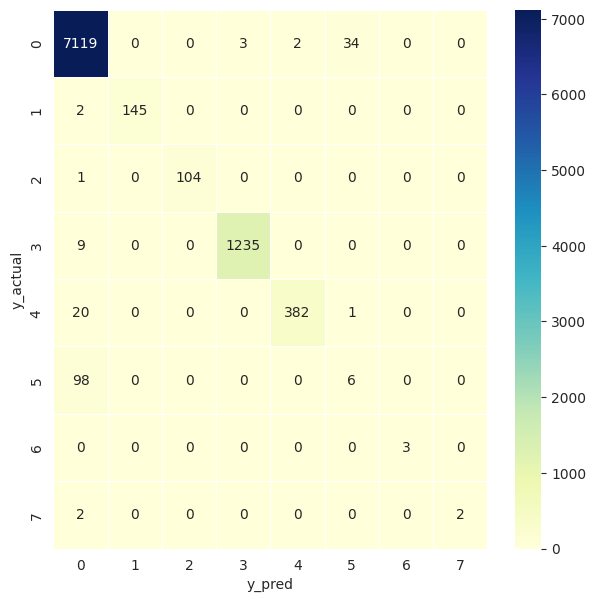

In [30]:
randomforest = RandomForestClassifier(random_state=7)
randomforest.fit(X_train, y_train)
rf_score = randomforest.score(X_test, y_test)
y_predict = randomforest.predict(X_test)
y_actual = y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall, fscore, none= precision_recall_fscore_support(y_actual, y_predict, average='weighted')
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_actual,y_predict))
cm=confusion_matrix(y_actual,y_predict)
f,ax=plt.subplots(figsize=(7,7))
sns.heatmap(cm, annot=True,linewidth=0.5, cmap="YlGnBu",fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_actual")
plt.show()

# Applying XG BOOST

[15:03:51] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGBoost: 0.9828752181500873
Precision of XGBoost: 0.9725067526182892
Recall of XGBoost: 0.9828752181500873
F1-score of XGBoost: 0.9776009727114068
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7158
           1       1.00      0.96      0.98       147
           2       0.99      0.99      0.99       105
           3       0.99      1.00      0.99      1244
           4       0.99      0.96      0.97       403
           5       0.00      0.00      0.00       104
           6       0.33      0.67      0.44         3
           7       1.00      0.75      0.86         4

    accuracy                        

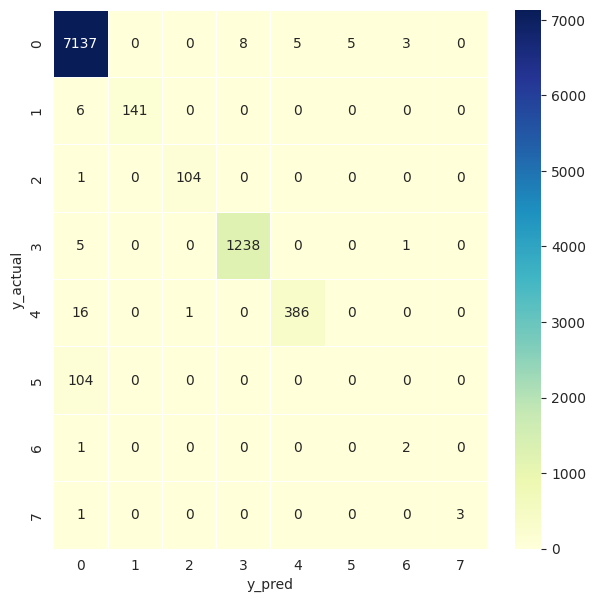

In [49]:
xgboost = xgb.XGBClassifier(n_estimators = 10)
xgboost.fit(X_train,y_train)
xgboost_score=xgboost.score(X_test,y_test)
y_predict=xgboost.predict(X_test)
y_actual=y_test
print('Accuracy of XGBoost: '+ str(xgboost_score))
precision, recall, fscore,none= precision_recall_fscore_support(y_actual, y_predict, average='weighted')
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_actual,y_predict))
cm=confusion_matrix(y_actual,y_predict)
f,ax=plt.subplots(figsize=(7,7))
sns.heatmap(cm,annot=True,linewidth=0.5, cmap="YlGnBu",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_actual")
plt.show()

## Applying Linear Discriminate Analysis

In [50]:
def apply_lda(X_train, X_test, y_train, y_actual, save=False):
    lda = LinearDiscriminantAnalysis(solver='svd')
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    lda_score = lda.score(X_test, y_actual)
    precision, recall, fscore, support = precision_recall_fscore_support \
        (y_actual, y_pred, average='weighted')

    print("Linear Discriminant Analysis")
    print(f"Accuracy: {lda_score}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {fscore}\n")
    print(classification_report(y_actual, y_pred))
    cm = confusion_matrix(y_actual, y_pred)
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidth=0.5,
                linecolor="black", cmap="YlGnBu", ax=ax)
    plt.title("Linear Discriminant Analysis - Confusion Matrix")
    plt.xlabel("Y - Predicted")
    plt.ylabel("Y - Actual")
    plt.show()
    if save:
        with open('./results/ids-lda/ids_lda_results.txt', 'w+') as f:
            print("Linear Discriminant Analysis", file=f)
            print(f"Accuracy: {lda_score}", file=f)
            print(f"Precision: {precision}", file=f)
            print(f"Recall: {recall}", file=f)
            print(f"F1 Score: {fscore}\n", file=f)
            print(classification_report(y_actual, y_pred), file=f)
            f.truncate()
        fig.savefig('./results/ids-lda/ids_lda_cm.jpeg')

Linear Discriminant Analysis
Accuracy: 0.8321335078534031
Precision: 0.8343624539093247
Recall: 0.8321335078534031
F1 Score: 0.8199052289545343

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      7158
           1       0.01      0.01      0.01       147
           2       0.44      0.92      0.60       105
           3       0.89      0.50      0.64      1244
           4       0.80      0.39      0.53       403
           5       0.00      0.00      0.00       104
           6       0.02      0.33      0.03         3
           7       0.04      0.75      0.08         4

    accuracy                           0.83      9168
   macro avg       0.38      0.48      0.35      9168
weighted avg       0.83      0.83      0.82      9168



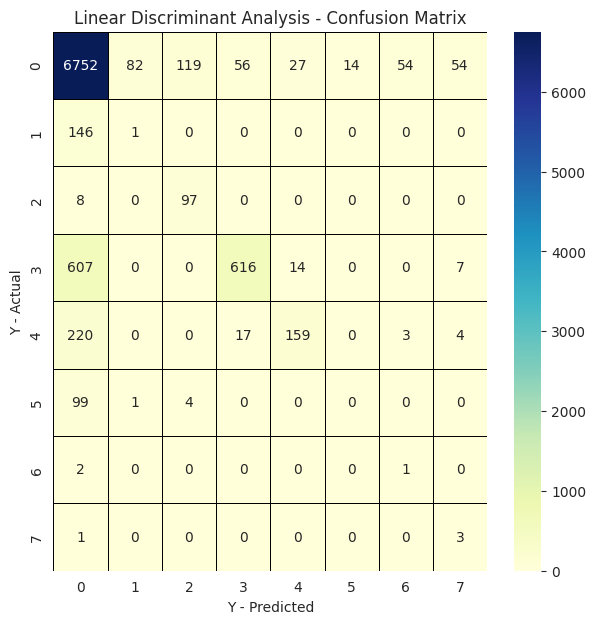

In [51]:
apply_lda(x_train, x_test, y_train, y_test)

## Applying the Ensemble Voting Classifier

In [57]:
from sklearn.ensemble import VotingClassifier
class IntrusionDS():

    # Random Forest Classifier
    def apply_rf(self, X_train, X_test, y_train, y_actual, save=False):
        rf = RandomForestClassifier(n_estimators=100)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        rf_score = rf.score(X_test, y_actual)
        precision, recall, fscore, support = precision_recall_fscore_support \
            (y_actual, y_pred, average='weighted')

        print("Random Forest")
        print(f"Accuracy: {rf_score}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {fscore}\n")
        print(classification_report(y_actual, y_pred))
        cm = confusion_matrix(y_actual, y_pred)
        fig, ax = plt.subplots(figsize=(7, 7))
        sns.heatmap(cm, annot=True, fmt=".0f", linewidth=0.5,
                    linecolor="black", cmap="YlGnBu", ax=ax)
        plt.title("Random Forest - Confusion Matrix")
        plt.xlabel("Y - Predicted")
        plt.ylabel("Y - Actual")
        plt.show()
        if save:
            with open('./results/ids-randomforest/ids_rf_results.txt', 'r+') as f:
                print("Random Forest", file=f)
                print(f"Accuracy: {rf_score}", file=f)
                print(f"Precision: {precision}", file=f)
                print(f"Recall: {recall}", file=f)
                print(f"F1 Score: {fscore}\n", file=f)
                print(classification_report(y_actual, y_pred), file=f)
                f.truncate()
            fig.savefig('./results/ids-randomforest/ids_rf_cm.jpeg')

    # XGBoost Classifier
    def apply_xgb(self, X_train, X_test, y_train, y_actual, save=False):
        xgboost = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False)
        xgboost.fit(X_train, y_train)
        y_pred = xgboost.predict(X_test)
        xgb_score = xgboost.score(X_test, y_actual)
        precision, recall, fscore, support = precision_recall_fscore_support \
            (y_actual, y_pred, average='weighted')

        print("XGBoost")
        print(f"Accuracy: {xgb_score}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {fscore}\n")
        print(classification_report(y_actual, y_pred))
        cm = confusion_matrix(y_actual, y_pred)
        fig, ax = plt.subplots(figsize=(7, 7))
        sns.heatmap(cm, annot=True, fmt=".0f", linewidth=0.5,
                    linecolor="black", cmap="YlGnBu", ax=ax)
        plt.title("XGBoost - Confusion Matrix")
        plt.xlabel("Y - Predicted")
        plt.ylabel("Y - Actual")
        plt.show()
        if save:
            with open('./results/ids-xgboost/ids_xgb_results.txt', 'r+') as f:
                print("XGBoost", file=f)
                print(f"Accuracy: {xgb_score}", file=f)
                print(f"Precision: {precision}", file=f)
                print(f"Recall: {recall}", file=f)
                print(f"F1 Score: {fscore}\n", file=f)
                print(classification_report(y_actual, y_pred), file=f)
                f.truncate()
            fig.savefig('./results/ids-xgboost/ids_xgb_cm.jpeg')

    # Linear Discriminant Analysis
    def apply_lda(self, X_train, X_test, y_train, y_actual, save=False):
        lda = LinearDiscriminantAnalysis(solver='svd')
        lda.fit(X_train, y_train)
        y_pred = lda.predict(X_test)
        lda_score = lda.score(X_test, y_actual)
        precision, recall, fscore, support = precision_recall_fscore_support \
            (y_actual, y_pred, average='weighted')

        print("Linear Discriminant Analysis")
        print(f"Accuracy: {lda_score}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {fscore}\n")
        print(classification_report(y_actual, y_pred))
        cm = confusion_matrix(y_actual, y_pred)
        fig, ax = plt.subplots(figsize=(7, 7))
        sns.heatmap(cm, annot=True, fmt=".0f", linewidth=0.5,
                    linecolor="black", cmap="YlGnBu", ax=ax)
        plt.title("Linear Discriminant Analysis - Confusion Matrix")
        plt.xlabel("Y - Predicted")
        plt.ylabel("Y - Actual")
        plt.show()
        if save:
            with open('./results/ids-lda/ids_lda_results.txt', 'w+') as f:
                print("Linear Discriminant Analysis", file=f)
                print(f"Accuracy: {lda_score}", file=f)
                print(f"Precision: {precision}", file=f)
                print(f"Recall: {recall}", file=f)
                print(f"F1 Score: {fscore}\n", file=f)
                print(classification_report(y_actual, y_pred), file=f)
                f.truncate()
            fig.savefig('./results/ids-lda/ids_lda_cm.jpeg')

    # Stacked Classifier - Voting Ensemble
    def fit_stacked(self, X_train, X_test, y_train, y_test, save=False):
        clf1 = RandomForestClassifier(n_estimators=100)
        clf2 = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False)
        clf3 = LinearDiscriminantAnalysis(solver='svd')

        eclf = VotingClassifier(estimators=[('rf', clf1), ('xgb', clf2), ('lda', clf3)], voting='hard')
        eclf.fit(X_train, y_train)
        eclf_score = eclf.score(X_test, y_test)
        y_predict = eclf.predict(X_test)
        y_actual = y_test
        print(f'Accuracy of Stacked Classifiers: {eclf_score}')
        precision, recall, fscore, none= precision_recall_fscore_support(y_actual, y_predict, average='weighted')
        print(f'Precision of Stacked Classifiers: {precision}')
        print(f'Recall of Stacked Classifiers: {recall}')
        print(f'F1-score of Stacked Classifiers: {fscore}')
        print(classification_report(y_actual,y_predict))
        cm=confusion_matrix(y_actual,y_predict)
        f,ax=plt.subplots(figsize=(7,7))
        sns.heatmap(cm,annot=True,linewidth=0.5, cmap="YlGnBu",fmt=".0f",ax=ax)
        plt.xlabel("y_pred")
        plt.ylabel("y_actual")
        plt.show()
        if save:
            with open('./results/ids-lda/ids_lda_results.txt', 'w+') as f:
                print("Linear Discriminant Analysis", file=f)
                print(f"Accuracy: {lda_score}", file=f)
                print(f"Precision: {precision}", file=f)
                print(f"Recall: {recall}", file=f)
                print(f"F1 Score: {fscore}\n", file=f)
                print(classification_report(y_actual, y_pred), file=f)
                f.truncate()
            fig.savefig('./results/ids-lda/ids_lda_cm.jpeg')

[15:10:59] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of Stacked Classifiers: 0.9830933682373473
Precision of Stacked Classifiers: 0.9741340006750525
Recall of Stacked Classifiers: 0.9830933682373473
F1-score of Stacked Classifiers: 0.978079145036209
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7158
           1       1.00      0.99      0.99       147
           2       1.00      0.99      1.00       105
           3       1.00      0.99      0.99      1244
           4       0.99      0.95      0.97       403
           5       0.10      0.01      0.02       104
           6       1.00      0.67      0.80         3
           7       1.00      0.75      0.86 

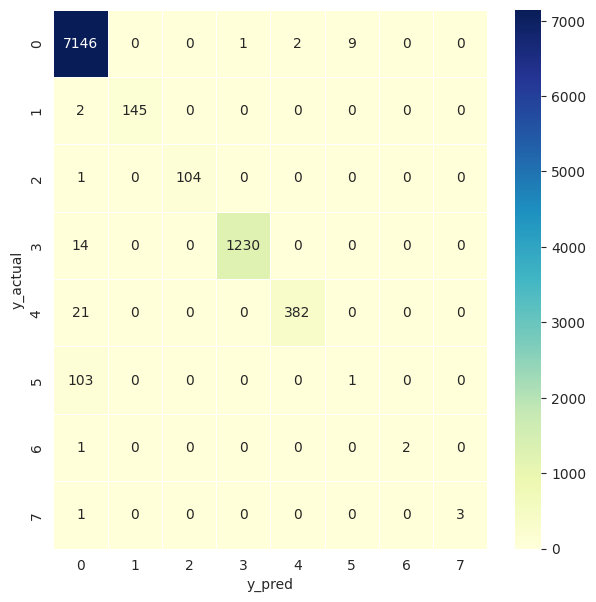

In [58]:
ids = IntrusionDS()
ids.fit_stacked(X_train,X_test, y_train, y_test)